# Final Project
### Computer vision and 3D Reconstruction Year: 2023-2024
**Student**: Raixa A. Madueño

---

**The following results show the version of the libraries and Python used to create the algorithm.**

---
In case you already have python, and the libraries: numpy, matplotlib and cv2.  
You can check your version of the libraries execute the following cell.

In [38]:
import sys
import matplotlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
print("Python version: {}".format(sys.version))
print("OpenCV version: {}".format(cv2.__version__))
print("Matplotlib version: {}".format(matplotlib.__version__))
print("NumPy version: {}".format(np.__version__))

Python version: 3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:40:31) [MSC v.1929 64 bit (AMD64)]
OpenCV version: 4.8.1
Matplotlib version: 3.8.1
NumPy version: 1.26.0


If you do not have the required libraries (numpy, matplotlib and cv2), execute this cell using the specified source code version.

In [ ]:
!conda install -c conda-forge opencv=4.5.3
!conda install -c conda-forge matplotlib=3.4.3
!conda install -c conda-forge numpy=1.21.2

## Method to create a panoramic view

---
To execute the following cell is needed to import the mandatory libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

The `preprocess_and_display_images` function performs the following operations:

1. **Loads Images**: It loads three images from the path+image name +format. The images are loaded in RGB.

2. **Determines Smallest Dimensions**: It determines the smallest width and height among the three images.

3. **Preprocesses Images**: It preprocesses each image using the `preprocess_image` function (not defined in the provided code). The preprocessing includes resizing each image to match the smallest width and height determined in the previous step.

4. **Displays Images**: If the `breakdown` parameter is set to `True`, it displays the preprocessed images using matplotlib's pyplot. The images are displayed in a 1x3 grid with the 'viridis' colormap.

5. **Returns Images**: Finally, it returns the preprocessed images.

The function aims to load, preprocess, and return three images from a specified directory.  
Preprocessing is based on the smallest dimensions among the three images to ensure consistency in subsequent operations.  
Optional image display aids in visually verifying preprocessing steps.  
The returned preprocessed images can be used for further analysis or model input.

In [16]:
def preprocess_and_display_images(path_image_name1,path_image_name2,path_image_name3,breakdown=False):

    # Charge the image in gray
    img1 = cv2.imread(path_image_name1, cv2.COLOR_GRAY2BGR)  # queryImage
    img2 = cv2.imread(path_image_name2, cv2.COLOR_GRAY2BGR)  # trainImage
    img3 = cv2.imread(path_image_name3, cv2.COLOR_GRAY2BGR)  # trainImage

    # Determine the smallest dimensions
    min_width = min(img1.shape[1], img2.shape[1], img3.shape[1])
    min_height = min(img1.shape[0], img2.shape[0], img3.shape[0])
    
    # Preprocess the images
    img1 = preprocess_image(img1, size=(min_width, min_height))
    img2 = preprocess_image(img2, size=(min_width, min_height))
    img3 = preprocess_image(img3, size=(min_width, min_height))
    if breakdown==True:
        #show the original images
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(img1, cmap='viridis')
        axs[0].set_title("Image 1")
        axs[1].imshow(img2, cmap='viridis')
        axs[1].set_title("Image 2")
        axs[2].imshow(img3, cmap='viridis')
        axs[2].set_title("Image 3")
        plt.show()
    return img1,img2,img3


The `preprocess_image` function performs the following operations:

1. **Determines Size**: If no size is provided as an argument, it uses the original size of the image.

2. **Calculates Aspect Ratio**: It calculates the aspect ratio of the image as the ratio of width to height.

3. **Calculates New Dimensions**: It calculates the new dimensions of the image while maintaining the aspect ratio. If the image is in landscape orientation (wide), it sets the new width to the provided size and calculates the new height. If the image is in portrait orientation (tall), it sets the new height to the provided size and calculates the new width.

4. **Resizes Image**: It resizes the image to the new dimensions using OpenCV's `cv2.resize` function.

5. **Normalizes Image**: It normalizes the pixel values of the resized image to the range 0 - 255 using OpenCV's `cv2.normalize` function and converts the normalized image to an 8-bit unsigned integer format.

6. **Returns Image**: Finally, it returns the normalized image.

The function aims to preprocess an image by resizing it to a specified size, or its original size if no size is provided while maintaining its aspect ratio and normalizing its pixel values. This preprocessed image can then be used for further analysis or model input. The function ensures consistent preprocessing across different images, regardless of their original sizes and orientations.

In [3]:
def preprocess_image(img, size=None):
    # If no size is provided, use the size of the image
    if size is None:
        size = img.shape[1], img.shape[0]  # width, height

    # Calculate the aspect ratio of the image
    aspect_ratio = img.shape[1] / img.shape[0]  # width / height

    # Calculate the new dimensions while maintaining aspect ratio
    if aspect_ratio > 1:
        # Landscape orientation - wide image
        new_width = size[0]
        new_height = round(new_width / aspect_ratio)
    else:
        # Portrait orientation - tall image
        new_height = size[1]
        new_width = round(new_height * aspect_ratio)

    # Resize the image
    img_resized = cv2.resize(img, (new_width, new_height))

    # Normalize the image to 0 - 255
    img_normalized = cv2.normalize(img_resized, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    return img_normalized

In [4]:
def descriptor_methods(image, method=None):    
    if method == 'sift' or method == None:
        descriptor = cv2.SIFT_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    # Obtaining key points and descriptors
    (kp, des) = descriptor.detectAndCompute(image, None)
    
    return (kp, des)

In [5]:
def create_BFMatcher(method):
    if method == 'sift' or method == None or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    elif method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    return bf

In [6]:
def obtain_matches(bf,des1,des2):
    #Obtaining the best matches from the key points
    matches = bf.knnMatch(des1, des2,k=2)
    # Store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    # Convert the remaining matches to a list of DMatch objects
    matches = [cv2.DMatch(_idx, _idx, 0) for _idx in range(len(good))]
    return good

In [7]:
def obtain_adapted_matrix(img,matrix):
    # Calculate the width of the non-overlapping part of img1 on the x-axis
    non_overlap_width = img.shape[1]*0.7
    # Create a translation matrix
    T = np.array([[1, 0, non_overlap_width], [0, 1, 0], [0, 0, 1]])
    # Creating the inverted matrix
    M2=np.linalg.inv(matrix)
    # Apply the translation to the inverted homography matrix
    M2 = np.dot(T, M2)
    return M2,non_overlap_width

In [8]:
def stitch_images_imgs(img1, img2,first_stt,method=None, breakdown=False):
    # Detect the features and the key points 
    kp1, des1 = descriptor_methods(img1, method=method)
    kp2, des2 = descriptor_methods(img2, method=method)
    #Select the descriptor method
    bf=create_BFMatcher(method=method)
    # Obtain good matches from the points obtained
    good=obtain_matches(bf,des1,des2)
       
    if breakdown == True:
        # Draw the remaining matches
        img_matches = cv2.drawMatchesKnn(img1,kp1,img2,kp2,[good],None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        # Display the result
        plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
        if first_stt==True:
            plt.title('Matches between img1 and img2')
        else:
            plt.title('Matches between result1 and img3')  
        plt.show()

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    # Obtaining the original homography matrix between img1 and img2
    M, _ = cv2.findHomography(dst_pts,src_pts, cv2.RANSAC)
    if first_stt==True:
        M, non_overlap_width=obtain_adapted_matrix(img2,M)
        # Warp img1 to img2's plane
        h1, w1 = img1.shape[:2]
        h2, w2 = img2.shape[:2]
        result = cv2.warpPerspective(img1, M, (w1 + w2, h1))
        # If img1_warped is grayscale, convert it to BGR
        if len(result.shape) == 2:
            result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)
        #It indicates the color of the image use red, green, and blue
        #Using the max height from the original images, and the sum of the 2 width of the 2 images
        output = np.zeros((max(h1, h2), w1 + w2 , 3), dtype=np.uint8)
        # Place img1_warped in the output image
        h1w, w1w = result.shape[:2]  # get the size of img1_warped
        # It copies the warped image into the left part of the result
        output[0:h1w, 0:w1w, :] = result
    else:
        output = cv2.warpPerspective(img2, M, (img1.shape[1] + img2.shape[1], img1.shape[0]))
        # If img1_warped is grayscale, convert it to BGR
        if len(output.shape) == 2:
            output = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)
        
    if breakdown == True:
        plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        if first_stt==True:
            plt.title('Img1 ready to fit the img2')
        else:
           plt.title('Img3 ready to fit the result1') 
        plt.show()
    if first_stt==True:
        # Blend img2 into the output image
        '''
        The for loop blends the second image (img2) into the output image. 
        For each pixel in img2, it checks if the corresponding pixel in output is black ([0, 0, 0]). 
        If it is, it sets alpha to 1.0, meaning that the pixel from img2 will be copied directly into output. 
        If it’s not black, it sets alpha to 0.5, meaning that the pixel in output will be a 
        blend of the pixels from img2 and output.
        '''
        for i in range(h2):
            for j in range(w2):
                if np.array_equal(output[i, j + int(non_overlap_width)], [0, 0, 0]):
                    alpha = 1.0
                else:
                    alpha = 0.5
                output[i, j + int(non_overlap_width), :] = alpha * img2[i, j, :] + (1 - alpha) * output[i, j + int(non_overlap_width), :]

        # Remove the black part of the image
        gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
        '''
        This line applies a binary threshold to the grayscale image. 
        Pixels with a value greater than 1 will be set to 255 (white), 
        and all other pixels will be set to 0 (black)
        '''
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        '''
        It finds the contours (the boundaries of the white regions) in the binary image.
        '''
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # This line finds the contour with the largest area.
        cnt = max(contours, key=cv2.contourArea)
        # It finds the smallest rectangle that contains the largest contour.
        x, y, w, h = cv2.boundingRect(cnt)
        '''
        This line crops the output image to the bounding rectangle. 
        This removes any black borders around the stitched images.
        '''
        output = output[y:y+h, x:x+w]
    else:
        output[:img1.shape[0], :img1.shape[1]] = img1
    return output


In [9]:
def equalize_histogram_color(img):
    if len(img.shape) < 3 or img.shape[2] != 3:
        # Handle the case where the input image is single-channel or does not have 3 channels
        return img

    # Convert the image to YCrCb color space
    img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

    # Split the image into its channels
    y, cr, cb = cv2.split(img_y_cr_cb)

    # Equalize the histogram of the Y channel
    y_eq = cv2.equalizeHist(y)

    # Merge the equalized Y channel back with the other channels
    img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))

    # Convert the image back to BGR color space
    img_bgr_eq = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCrCb2BGR)

    return img_bgr_eq

The method `create_panorama` has these parameters:  

1. **path_image_name1,path_image_name2,path_image_name3** the method is designed to load three images that are part of a set these are the 3 variables for the images to input. The images are expected to be in order.
2. **breakdown** is a boolean parameter if it has the value the method just shows the final result.  Other than that, it displays the matches between the first and second images, the intermediate results, and the matches between the first result and the third image, as well as the original images.
3. **method** is a string where the values have to be sift or brisk to select the descriptor.
4. **normalize** if is true apply a color normalization over the final panorama view.


In [12]:
def create_panorama(path_image_name1,path_image_name2,path_image_name3,breakdown=False,method=None,normalize=True):
    img1,img2,img3=preprocess_and_display_images(path_image_name1,path_image_name2,path_image_name3,breakdown)
    result1=stitch_images_imgs(img1, img2,True,method,breakdown)
    if breakdown==True:
        plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
        plt.title('Result of the merge of image 1 and 2')
        plt.show()
    panorama=stitch_images_imgs(result1, img3,False,method,breakdown)
    #panorama = equalize_histogram_color(panorama)
    if normalize==False:
        plt.figure(figsize=(10,5))
        plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
        plt.title('Panorama')
        plt.show()
    else:
        panorama = equalize_histogram_color(panorama)
        plt.figure(figsize=(10,5))
        plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
        plt.title('Panorama Normalize')
        plt.show()
  

## Example of images that challenge the method

---


In [19]:
image_name='g6'

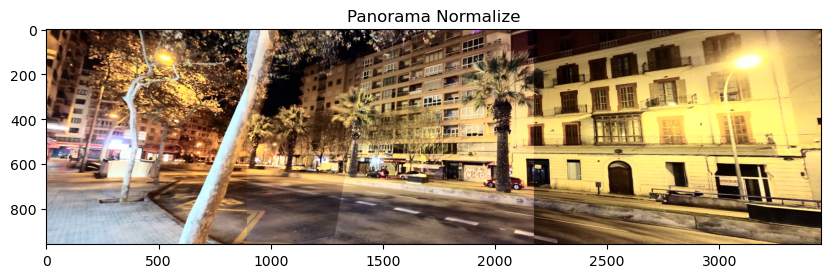

In [22]:
path_image_name1=f'sources/{image_name}_pt1.jpeg'
path_image_name2=f'sources/{image_name}_pt2.jpeg'
path_image_name3=f'sources/{image_name}_pt3.jpeg'
create_panorama(path_image_name1,path_image_name2,path_image_name3,False,'sift')

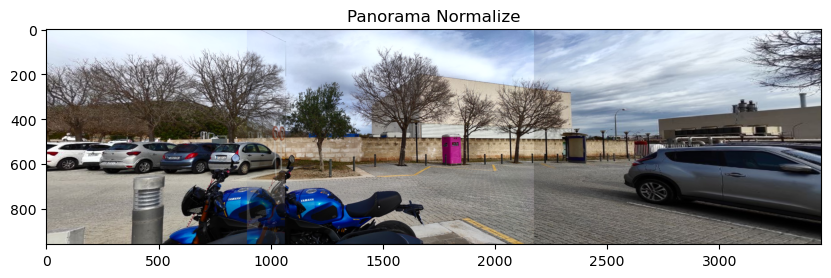

In [24]:
image_name='g5'
path_image_name1=f'sources/{image_name}_pt1.jpeg'
path_image_name2=f'sources/{image_name}_pt2.jpeg'
path_image_name3=f'sources/{image_name}_pt3.jpeg'
create_panorama(path_image_name1,path_image_name2,path_image_name3,False,'sift')

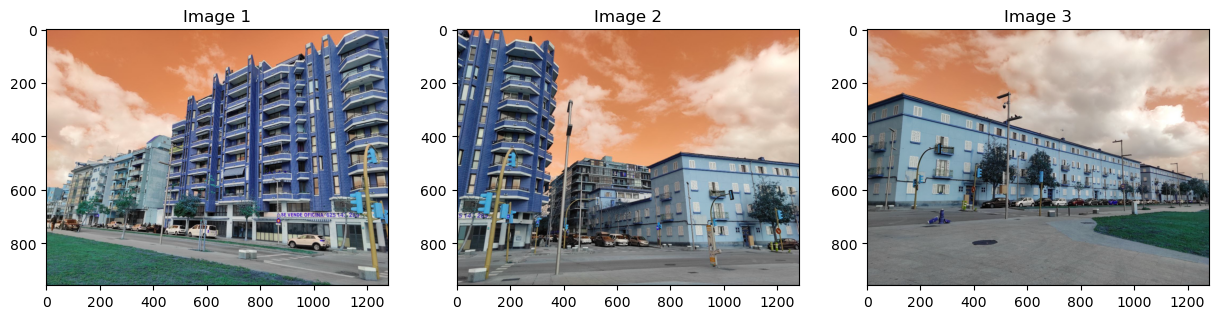

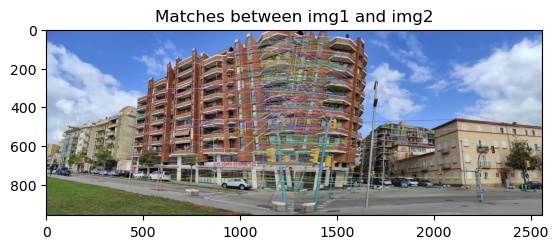

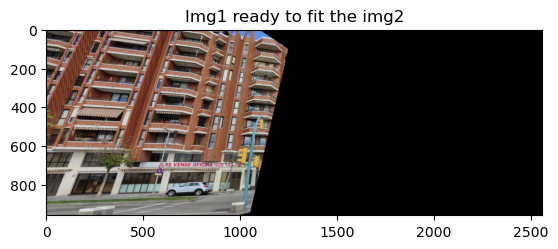

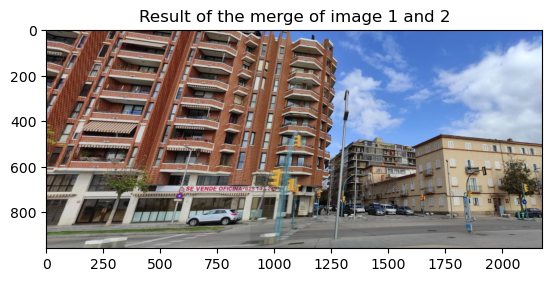

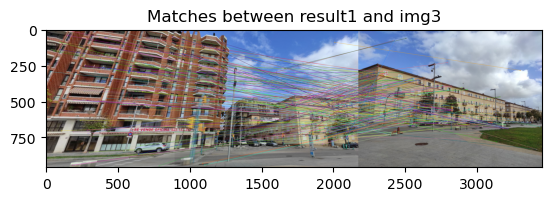

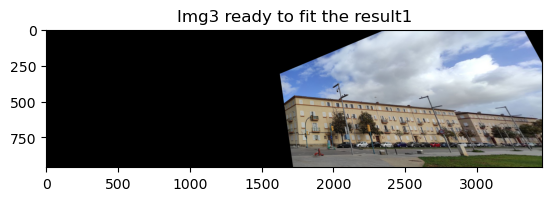

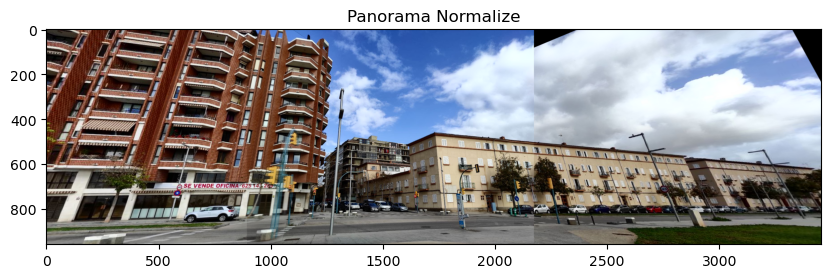

In [25]:
image_name='g1'
path_image_name1=f'sources/{image_name}_pt1.jpeg'
path_image_name2=f'sources/{image_name}_pt2.jpeg'
path_image_name3=f'sources/{image_name}_pt3.jpeg'
create_panorama(path_image_name1,path_image_name2,path_image_name3,True,'sift')